# <center>Sparse Gaussian Models Vignette</center>

This notebook illustrates how to use the methods in the Sparse Supervised Gaussian library. We shall generate some sparse structures and data samples, run the various methods, visualise the learned models, and compute performance metrics.

# Header

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from itertools import chain, product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from py2r import *
import seaborn as sns
from sklearn.datasets import make_spd_matrix
from sklearn.metrics import auc, roc_curve, classification_report

# Utility Functions

In [3]:
def plotHeatmaps(heatmaps, titles=None):
  """Takes a list of lists of matrices and plots them as a grid of heatmaps."""
  nr = len(heatmaps)
  nc = len(heatmaps[0])

  # Find min and max values across matrices.
  # We use this to align the heatmap scales.
  hmMin = np.min([ M.min() for M in chain.from_iterable(heatmaps) ])
  hmMax = np.max([ M.max() for M in chain.from_iterable(heatmaps) ])

  figure, axes = plt.subplots(nr, nc, figsize=(8*nc, 6*nr))

  # I want to pass the elements of the axes array to seaborn's heatmap function.
  # However, axes contains AxesSubplot objects, while heatmap appears to need an Axes object.
  # Somehow, the flat accessor is doing this conversion. I don't understand why,
  # and I don't know what is the proper way to do the conversion. But... it works!
  axes = np.array([x for x in axes.flat]).reshape(nr, nc)

  for r in range(nr):
    for c in range(nc):
      sns.heatmap(heatmaps[r][c], vmin=hmMin, vmax=hmMax, center=0, annot=True, ax=axes[r][c])
      if titles is not None:
        axes[r][c].set_title(titles[r][c])

In [4]:
def plotROC(actual, scores):
  fpr, tpr, _ = roc_curve(actual, scores)
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (AUC = %0.2f)' % auc(fpr, tpr))
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc="lower right")

# Data Generation

In [5]:
def isPD(A):
  """Test whether a symmetric matrix is positive definite."""
  try:
    np.linalg.cholesky(A)
  except np.linalg.LinAlgError:
    return False
  return True

In [6]:
def genRegressionWeights(nC, sparsity, pX, pY):
  """Generate regression weights as a list of sparse matrices."""
  # Use pX+1 because we include an intercept term.
  B = [None]*nC
  for i in range(nC):
    Bmask = np.random.binomial(1, sparsity, [pX+1, pY])
    B[i] = np.random.randn(pX+1, pY) * Bmask
  return B

In [7]:
def genPrecisions(nC, sparsity, pY):
  """Return a list of sparse precisions and a corresponding list of covariances."""
  K = [None]*nC
  S = [None]*nC

  # Generate a random sparse precision matrix for each class.
  for i in range(nC):
    # Generate the sparsity pattern.
    Kmask = np.random.binomial(1, sparsity, [pY, pY])
    Kmask[np.tril_indices(pY, -1)] = 0
    Kmask = Kmask + Kmask.T
    np.fill_diagonal(Kmask, 1)

    # Generate a symmetric positive definite matrix with the given sparsity pattern.
    Ki = make_spd_matrix(pY) * Kmask
    Ki = (Ki + Ki.T) / 2
    while not isPD(Ki):
      Ki = Ki + np.eye(pY)

    K[i] = Ki
    S[i] = np.linalg.inv(Ki)

  return K, S

In [8]:
def genSamples(N, B, S):
  nC = len(B)
  pX = B[0].shape[0] - 1
  pY = B[0].shape[1]
  
  X = [None]*nC
  Y = [None]*nC
  for i in range(nC):
    # Set the first column of X all ones for the intercept.
    X[i] = np.ones([N, pX+1])
    X[i][:,1:] = np.random.randn(N, pX)
    Y[i] = np.dot(X[i], B[i]) + np.random.multivariate_normal(np.zeros(pY), S[i], N)

  return X, Y

In [9]:
def stackAndShuffle(X, Y):
  pX = X[0].shape[1]
  pY = Y[0].shape[1]

  XYC = np.vstack([
    np.hstack([x, y, np.full([x.shape[0],1], c)])
    for c, (x, y) in enumerate(zip(X, Y)) ])
  np.random.shuffle(XYC)

  return XYC[:,0:pX], XYC[:,pX:-1], XYC[:,-1]

# 2-Class Dataset

In [10]:
nC = 2  # Number of classes.
pX = 3  # Dimension of predictors.
pY = 5  # Dimension of targets.

Nis = 1000  # Number of in-sample data points per class (training data).
Nos = 1000  # Number of out-of-sample data points per class (testing data).

sB = 0.5  # Sparsity of the regression weights.
sK = 0.5  # Sparsity of the precision matrices.

In [11]:
# Set the RNG seed so that the same data are generated when the notebook is re-run.
np.random.seed(10)

In [12]:
B    = genRegressionWeights(nC, sB, pX, pY)
K, S = genPrecisions(nC, sK, pY)

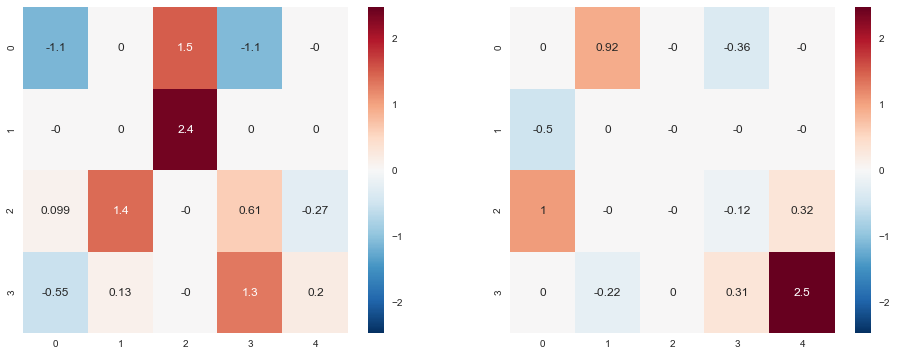

In [13]:
plotHeatmaps([B])

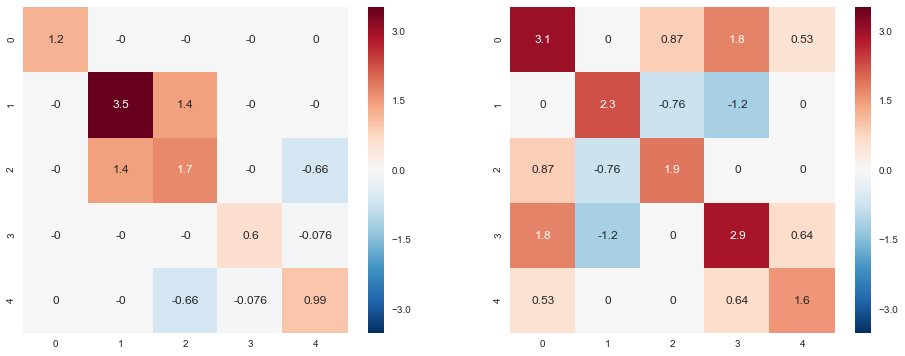

In [14]:
plotHeatmaps([K])

In [15]:
Xis, Yis = genSamples(Nis, B, S)
Xos, Yos = genSamples(Nos, B, S)

In [16]:
XXis, YYis, CCis = stackAndShuffle(Xis, Yis)
XXos, YYos, CCos = stackAndShuffle(Xos, Yos)

In [17]:
# Strip the column of ones for the intercept.
XXis = XXis[:,1:]
XXos = XXos[:,1:]

### Empirical Gaussian

**Method Overview:** Fit an empirical Gaussian to each class, ie use the maximum likelihood precision matrix. This results in dense structures. It is a baseline against which to compare the other models. The predictions are via linear discriminant classifiers.

In [18]:
from ccEmpGaussian import *

In [19]:
model = ccEmpGaussianFit(YYis, CCis.astype(bool))

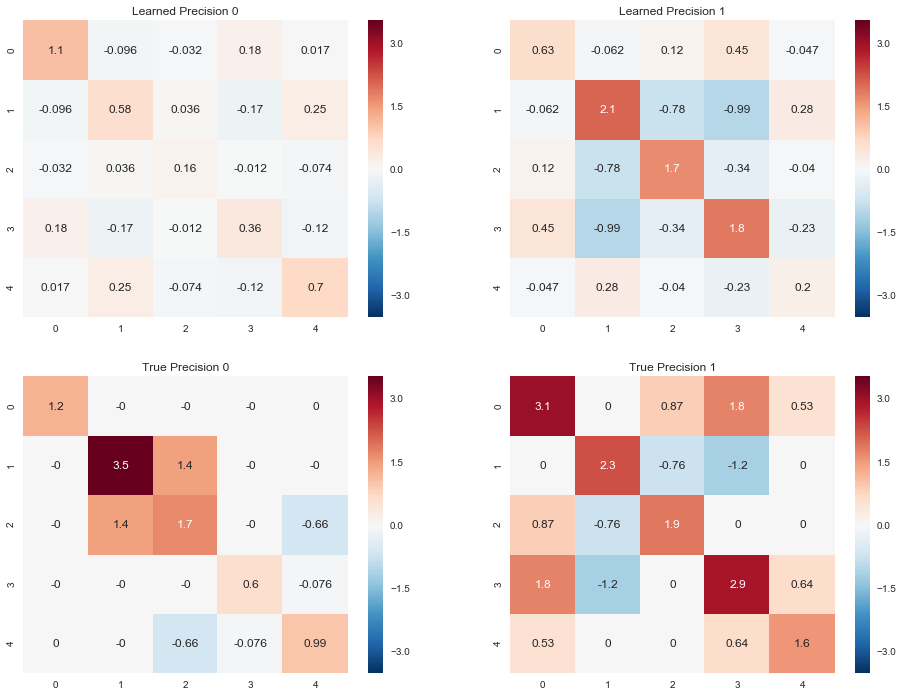

In [20]:
plotHeatmaps(
  [[np.linalg.inv(model['cova0']), np.linalg.inv(model['cova1'])], K],
  [['Learned Precision 0', 'Learned Precision 1'], ['True Precision 0', 'True Precision 1']] )

The empirical Gaussian is not a sparse method, so no structure is learned. The learned precisions do not look much like the true precisions; this is to be expected because there has been no adjustment for the covariates X.

             precision    recall  f1-score   support

    Class 0       0.94      0.89      0.91      1000
    Class 1       0.90      0.94      0.92      1000

avg / total       0.92      0.92      0.92      2000



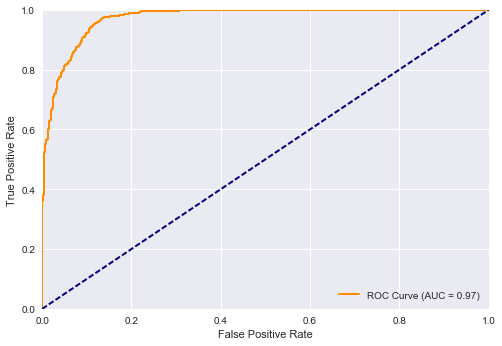

In [21]:
p1 = ccEmpGaussianPredict(model, YYos)
print( classification_report(CCos, p1 > 0.5, target_names=['Class 0', 'Class 1']) )
plotROC(CCos, p1)

Despite the poor match of the precisions to the ground truth, prediction performance is very good; this is an easy classification task.

### Class-Conditional Graphical Lasso

**Method Overview:** Train a graphical lasso model for each class; the predictions are via linear discriminant classifiers with the sparse class-conditional structures.

In [22]:
from ccGlasso import *

In [23]:
penRange = np.logspace(-3, 0, 10)

In [24]:
penRange

array([ 0.001     ,  0.00215443,  0.00464159,  0.01      ,  0.02154435,
        0.04641589,  0.1       ,  0.21544347,  0.46415888,  1.        ])

In [25]:
model, bestPen0, bestPen1 = ccGlassoCV(YYis, CCis.astype(bool), np.array(list(product(penRange, penRange))), 10)

In [26]:
bestPen0, bestPen1

(0.0021544346900318843, 0.021544346900318832)

Cross-validation has selected a very small penalty for the first class, and a mid-range penalty for the second.

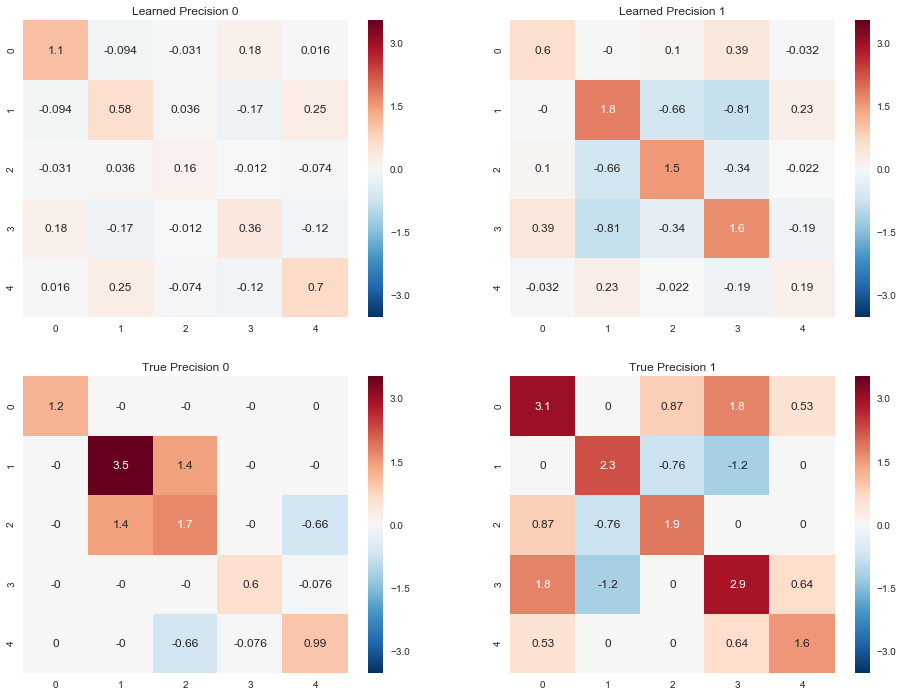

In [27]:
plotHeatmaps(
  [[model['prec0'], model['prec1']], K],
  [['Learned Precision 0', 'Learned Precision 1'], ['True Precision 0', 'True Precision 1']] )

One of the zeros in the second precision matrix has been found, but otherwise the precisions remain dense. Again, this is to be expected because there is no adjustment for covariates.

             precision    recall  f1-score   support

    Class 0       0.94      0.89      0.91      1000
    Class 1       0.89      0.95      0.92      1000

avg / total       0.92      0.92      0.92      2000



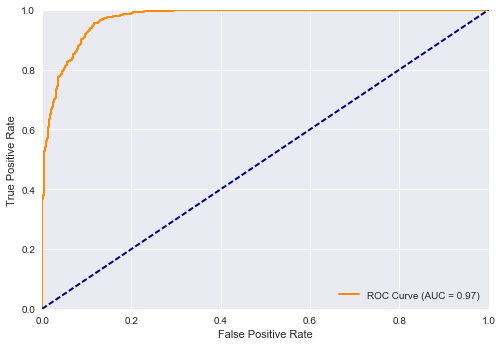

In [28]:
p1 = ccGlassoPredict(model, YYos)
print( classification_report(CCos, p1 > 0.5, target_names=['Class 0', 'Class 1']) )
plotROC(CCos, p1)

Classification performance is much the same as for the empirical Gaussian method on this synthetic data.

### Class-Conditional Graphical Lasso With Stability Selection

**Method Overview:** Pre-learn the structure of each class using stability selection (Meinshausen and Bühlmann, 2010) with thresholding, then run graphical lasso.

In [29]:
model = ccGlassoPreSS(
  YYis, CCis.astype(bool),
  thresholdRange=[0.05, 0.1, 0.2], fpr=0.1,
  penPrec0=bestPen0, penPrec1=bestPen1 )

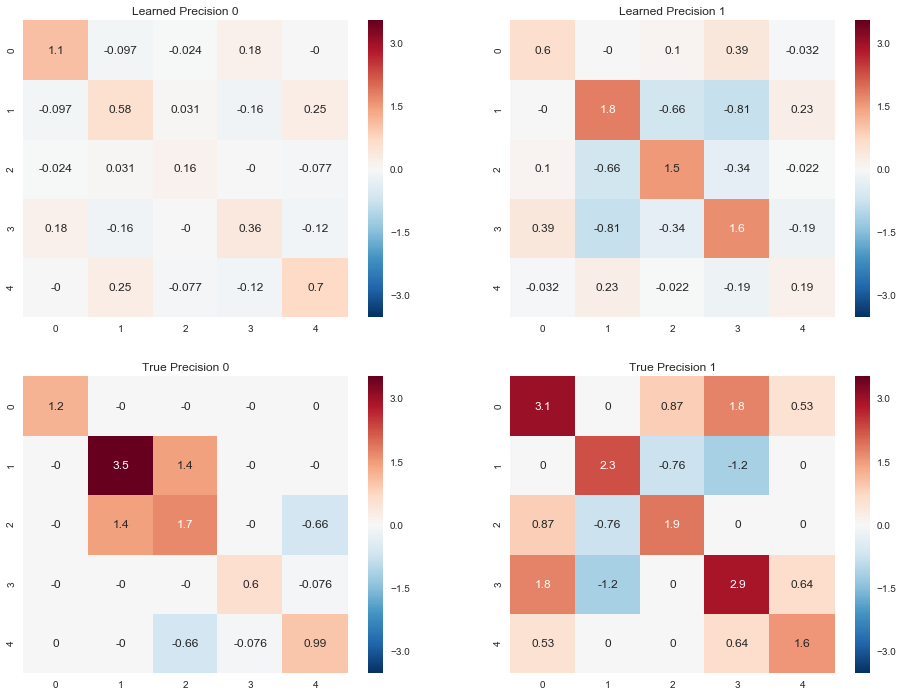

In [30]:
plotHeatmaps(
  [[model['prec0'], model['prec1']], K],
  [['Learned Precision 0', 'Learned Precision 1'], ['True Precision 0', 'True Precision 1']] )

Using stability selection to pre-learn the structure, 2 of the zeros in the first precision matrix are found.

             precision    recall  f1-score   support

    Class 0       0.94      0.89      0.91      1000
    Class 1       0.89      0.95      0.92      1000

avg / total       0.92      0.92      0.92      2000



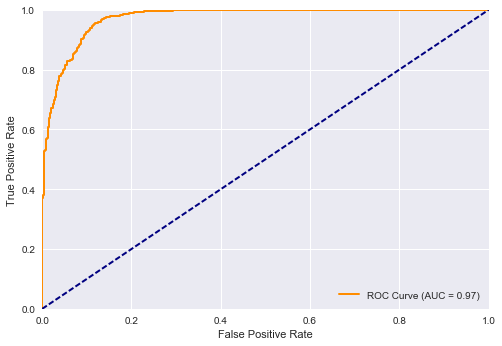

In [31]:
p1 = ccGlassoPredict(model, YYos)
print( classification_report(CCos, p1 > 0.5, target_names=['Class 0', 'Class 1']) )
plotROC(CCos, p1)

Classification performance remains the same as for the previous two methods.

### Class-Conditional MRCE

**Method Overview:** Fit an MRCE model for each class. The predictions are by an application of Bayes rule combining priors over the class label with the conditionally-trained MRCE.

In [32]:
from ccMRCE import *

In [33]:
# ccMRCE (as well as the other models in this package) is often used in situations
# where we expect the regression and precision parameters to be similar in each class.
# So, to save computation time, we only consider combinations of penalties for CV in
# which the regression and precision penalties are the same for each class.
penRangeB = np.logspace(-3, 0, 10)
penRangeK = np.logspace(-3, 0, 10)
penRange = np.array([ (pB, pB, pK, pK) for pB in penRangeB
                                       for pK in penRangeK ])

In [34]:
model, bestPens = ccmrceCV(XXis, YYis, CCis.astype(bool), penRange, 10)

In [35]:
bestPens[0], bestPens[2]

(0.0046415888336127772, 0.001)

In [36]:
B0 = np.vstack([ pyArrayFromRVector(model[0] + '$muhat'), pyArrayFromRVector(model[0] + '$Bhat') ])
B1 = np.vstack([ pyArrayFromRVector(model[1] + '$muhat'), pyArrayFromRVector(model[1] + '$Bhat') ])
K0 = pyArrayFromRMatrix(model[0] + '$omega')
K1 = pyArrayFromRMatrix(model[1] + '$omega')

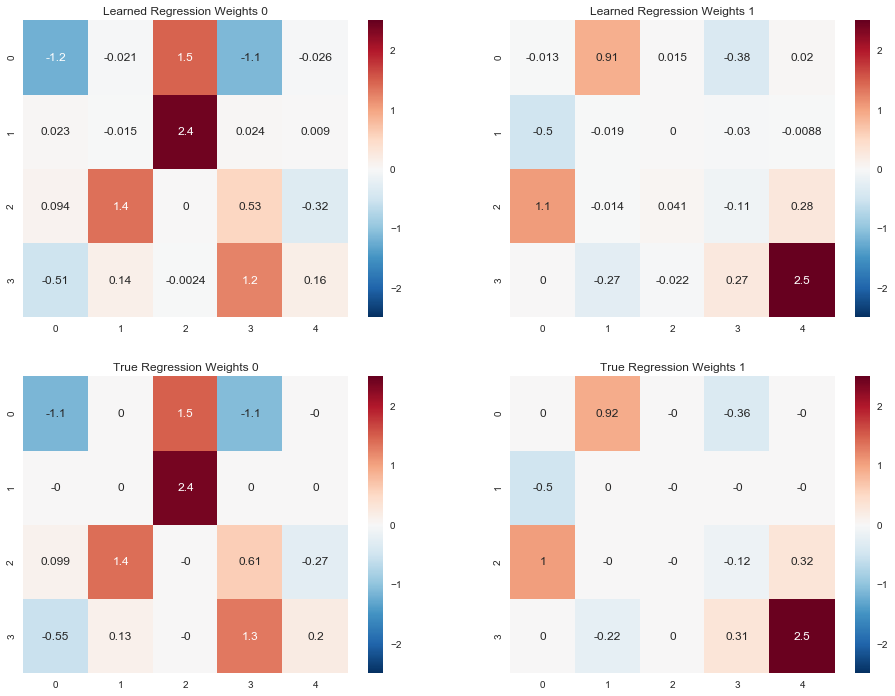

In [37]:
plotHeatmaps( [[B0, B1], B],
  [['Learned Regression Weights 0', 'Learned Regression Weights 1'],
   ['True Regression Weights 0', 'True Regression Weights 1']] )

Although not as sparse as the ground truth matrices, the learned regression coefficients are very close to the true values.

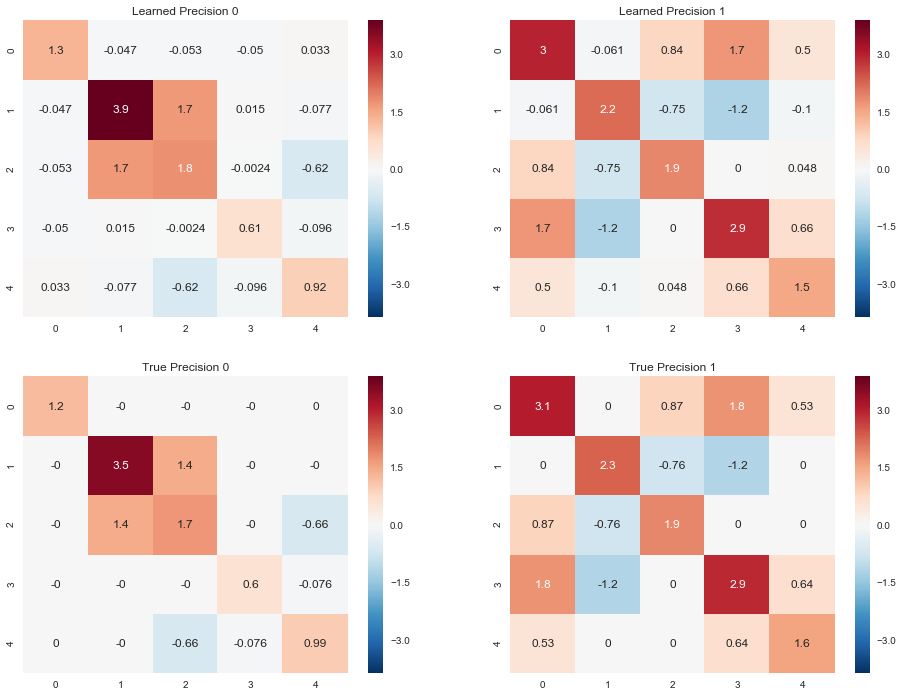

In [38]:
plotHeatmaps(
  [[K0, K1], K],
  [['Learned Precision 0', 'Learned Precision 1'],
   ['True Precision 0', 'True Precision 1']] )

As for the regression coefficients, the learned precisions are a little dense here, but the learned values are close to ground truth.

             precision    recall  f1-score   support

    Class 0       0.99      0.98      0.98      1000
    Class 1       0.98      0.99      0.98      1000

avg / total       0.98      0.98      0.98      2000



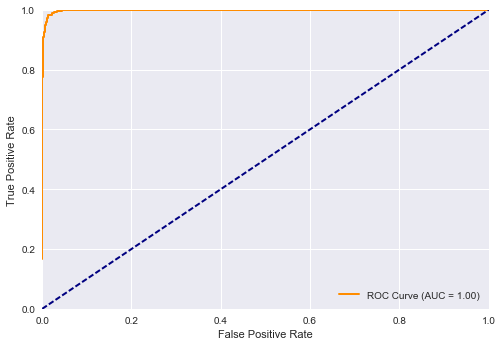

In [39]:
p1 = ccmrcePredict(*model, XXos, YYos)
print( classification_report(CCos, p1 > 0.5, target_names=['Class 0', 'Class 1']) )
plotROC(CCos, p1)

Classification performance is almost perfect - which is to be expected since the synthetic data were generated from the same model.

In [40]:
# Clean up the R workspace.
rRemove([ model[0], model[1] ])

### Mixture of Graphical Lasso

**Method Overview:** Like ccMRCE, but the class priors P(C|X) depend on the side information via a multinomial logit model.

In [41]:
from mGlasso import *

In [42]:
penRangePr = np.logspace(-1, 1, 10)
penRangeB  = np.logspace(-3, 0, 10)
penRangeK  = np.logspace(-3, 0, 10)
penRange = np.array([ (pPr, pB, pB, pK, pK) for pPr in penRangePr
                                            for pB  in penRangeB
                                            for pK  in penRangeK ])

In [43]:
model, bestPens = mGlassoCV(XXis, YYis, CCis.astype(bool), penRange, 10)

In [44]:
bestPens[0], bestPens[1], bestPens[3]

(10.0, 0.10000000000000001, 0.01)

In [45]:
B0 = np.vstack([ pyArrayFromRVector(model[0] + '$muhat'), pyArrayFromRVector(model[0] + '$Bhat') ])
B1 = np.vstack([ pyArrayFromRVector(model[1] + '$muhat'), pyArrayFromRVector(model[1] + '$Bhat') ])
K0 = pyArrayFromRMatrix(model[0] + '$omega')
K1 = pyArrayFromRMatrix(model[1] + '$omega')

The B and K parameters are trained in the same way as for ccMRCE, so the results may look similar. However, CV could select different penalties; and randomness in CV, training methods, and parameter initialisation could produce differences.

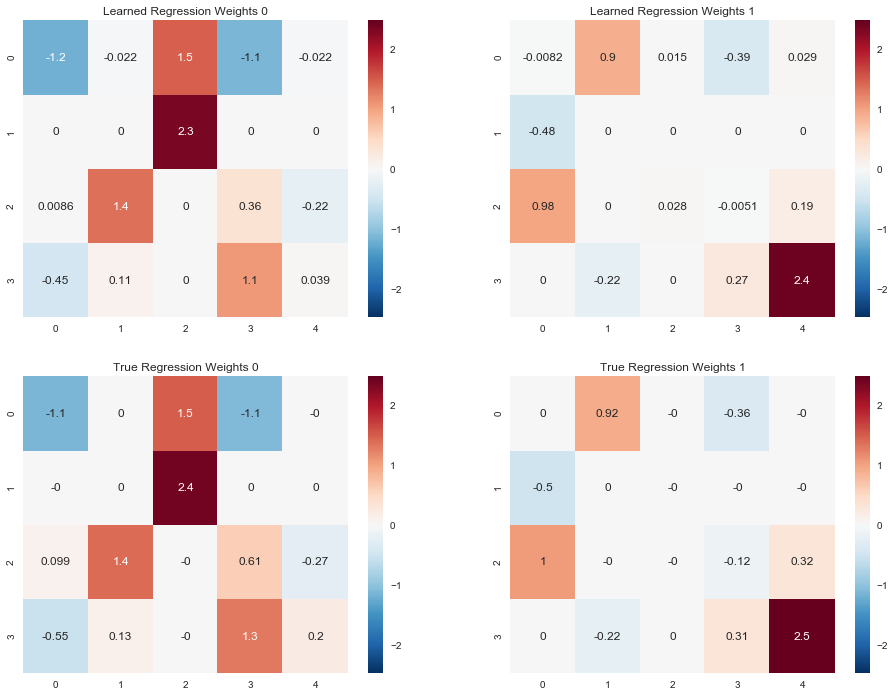

In [46]:
plotHeatmaps( [[B0, B1], B],
  [['Learned Regression Weights 0', 'Learned Regression Weights 1'],
   ['True Regression Weights 0', 'True Regression Weights 1']] )

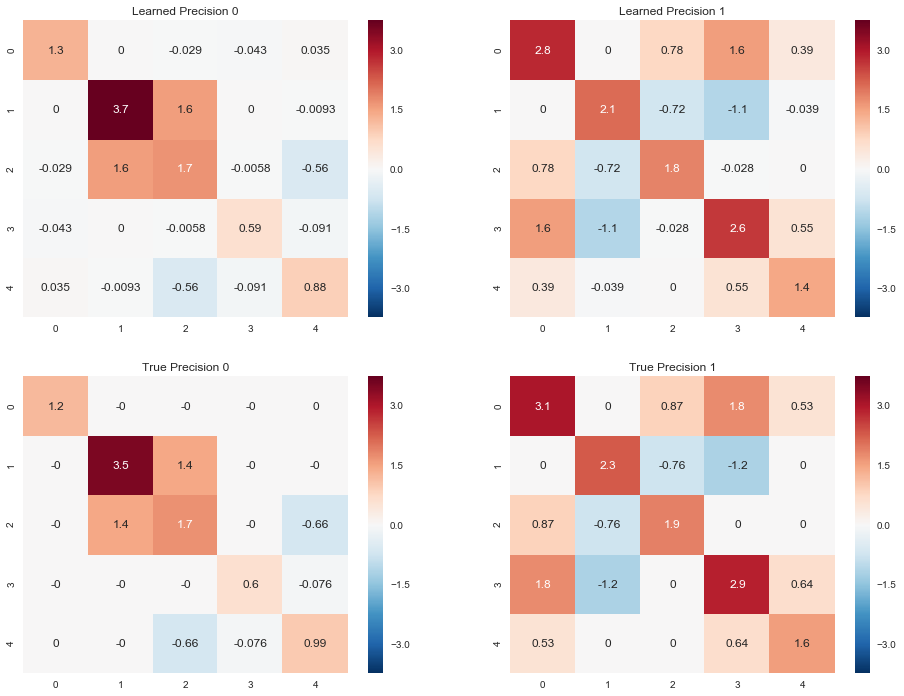

In [47]:
plotHeatmaps(
  [[K0, K1], K],
  [['Learned Precision 0', 'Learned Precision 1'],
   ['True Precision 0', 'True Precision 1']] )

Here are the learned parameters of the class prior. They are all small because in this synthetic data, the class prior is independent of the covariates.

In [48]:
priorModel = model[2]
np.hstack([priorModel.intercept_, priorModel.coef_.ravel()])

array([-0.00105549,  0.0261891 ,  0.04453482,  0.01057994])

             precision    recall  f1-score   support

    Class 0       0.99      0.98      0.98      1000
    Class 1       0.98      0.99      0.98      1000

avg / total       0.98      0.98      0.98      2000



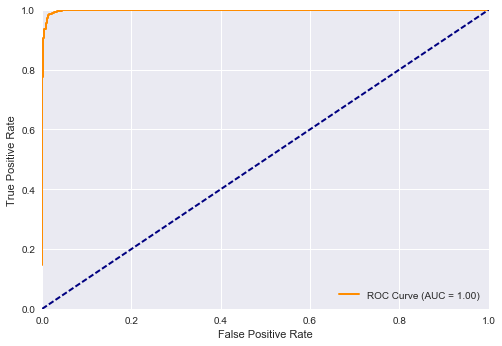

In [49]:
p1 = mGlassoPredict(*model, XXos, YYos)
print( classification_report(CCos, p1 > 0.5, target_names=['Class 0', 'Class 1']) )
plotROC(CCos, p1)

In [50]:
# Clean up the R workspace.
rRemove([ model[0], model[1] ])

### Class-Conditional Gaussian Graphical Model

**Method Overview:** Uses the approach of Opgen-Rhein and Strimmer (2006), followed by thresholding of the precision entries, to fit a sparse Gaussian model to each class. The predictions are via linear discriminant classifiers with the post-thresholding sparse structures.

In [51]:
from ccGGM import *

In [52]:
model = ccggmFit(XXis, YYis, CCis.astype(bool))

In [53]:
# ccGGM accounts for the covariates by fitting joint Gaussians to X and Y.
# Here, we extract the conditional precisions for comparison with the ground truth.
K0 = np.linalg.inv(model['cova0'])[pX:,pX:]
K1 = np.linalg.inv(model['cova1'])[pX:,pX:]

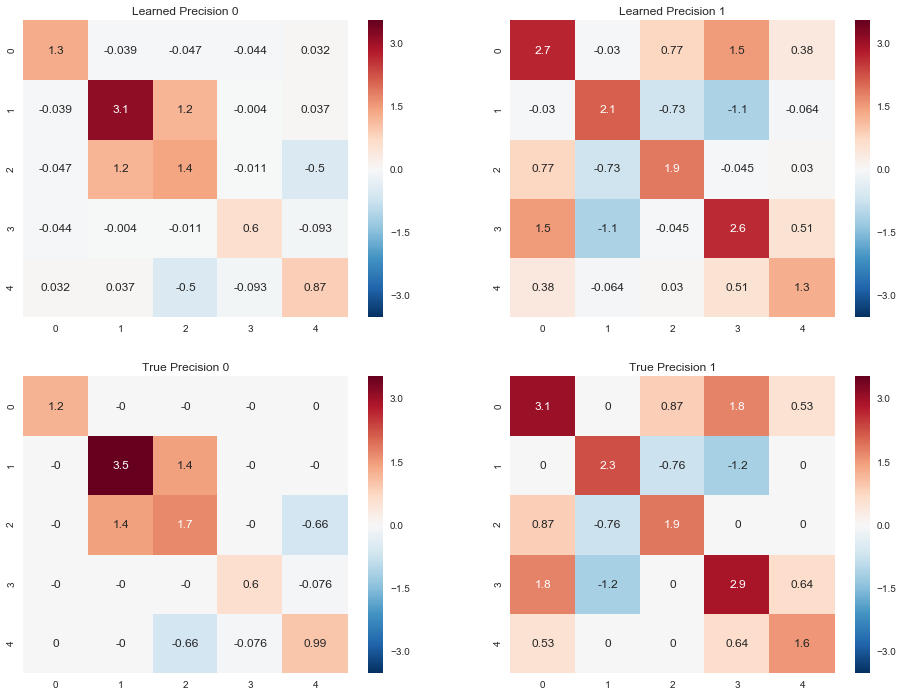

In [54]:
plotHeatmaps(
  [[K0, K1], K],
  [['Learned Precision 0', 'Learned Precision 1'], ['True Precision 0', 'True Precision 1']] )

The learned precisions match the ground truth quite well.

             precision    recall  f1-score   support

    Class 0       0.99      0.98      0.98      1000
    Class 1       0.98      0.99      0.98      1000

avg / total       0.98      0.98      0.98      2000



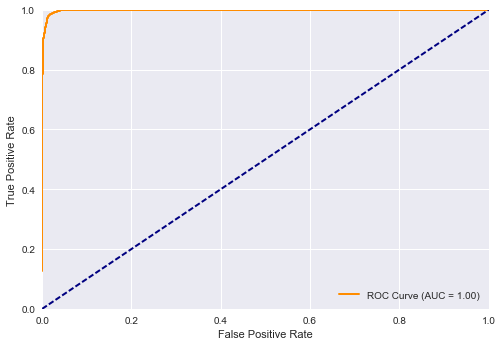

In [55]:
p1 = ccggmPredict(model, XXos, YYos)
print( classification_report(CCos, p1 > 0.5, target_names=['Class 0', 'Class 1']) )
plotROC(CCos, p1)

Classification performance is nearly perfect on this simple synthetic dataset.

# 3-Class Dataset

In [56]:
nC = 3  # Number of classes.
pX = 3  # Dimension of predictors.
pY = 5  # Dimension of targets.

Nis = 1000  # Number of in-sample data points per class (training data).
Nos = 1000  # Number of out-of-sample data points per class (testing data).

sB = 0.5  # Sparsity of the regression weights.
sK = 0.5  # Sparsity of the precision matrices.

In [57]:
np.random.seed(20)

In [58]:
B    = genRegressionWeights(nC, sB, pX, pY)
K, S = genPrecisions(nC, sK, pY)

To test the cFGL, set 2 of the regression weight matrices equal, and 2 precisions equal.

In [59]:
B[0] = B[1]
K[1] = K[2]
S[1] = S[2]

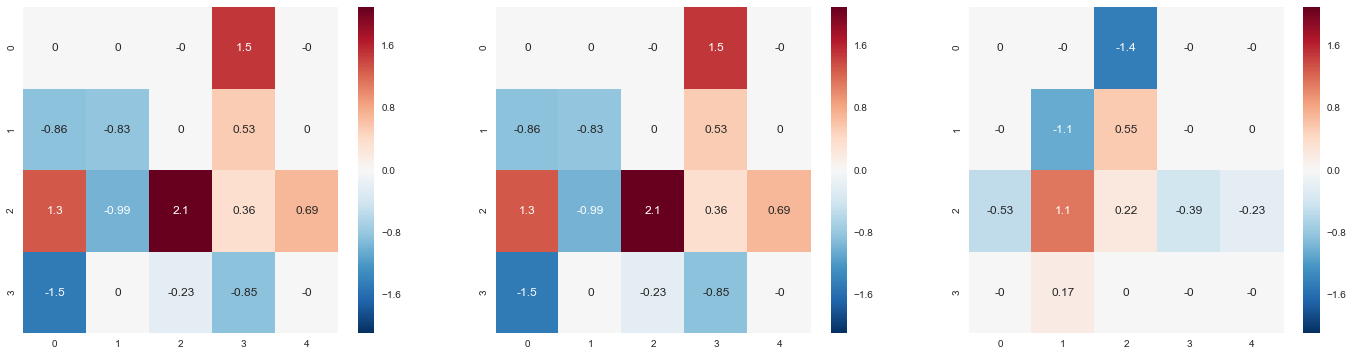

In [60]:
plotHeatmaps([B])

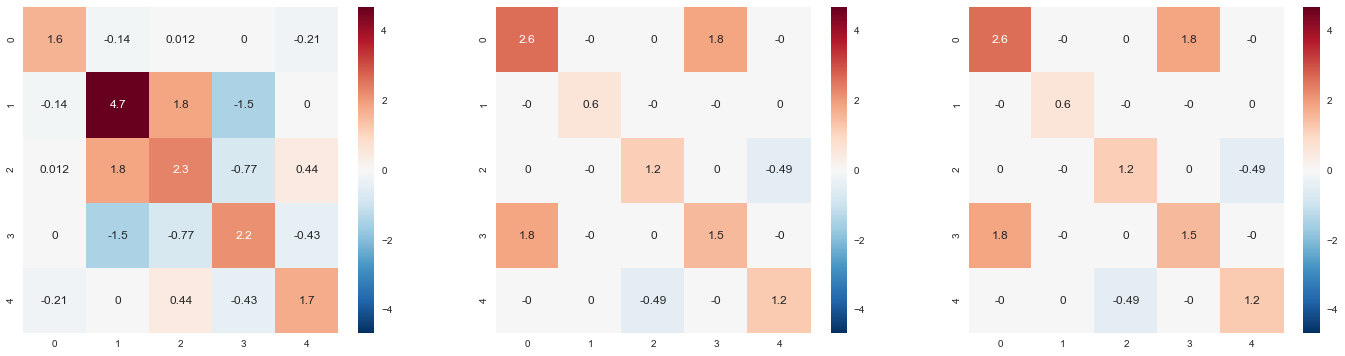

In [61]:
plotHeatmaps([K])

In [62]:
Xis, Yis = genSamples(Nis, B, S)
Xos, Yos = genSamples(Nos, B, S)

In [63]:
# Strip column of ones from each element of X.
for i in range(nC):
  Xis[i] = Xis[i][:,1:]
  Xos[i] = Xos[i][:,1:]

In [64]:
XXos, YYos, CCos = stackAndShuffle(Xos, Yos)

### Conditional Fused Graphical Lasso

**Method Overview:** The fused graphical lasso (Danaher et al, 2014) fits multiple graphical lasso models while imposing a penalty on differences between the structures. Our method cFGL generalises this by introducing covariates and by imposing penalties on the differences between the regression parameters for each class. This approach “marries” the joint fused graphical lasso method with the MRCE and uses a new iterative convex optimization procedure to learn the parameters. The predictions are by an application of Bayes rule combining lasso regression of the class label on the side information with the class-conditional MRCE, where the training penalized large differences between the model parameters corresponding to each class.

The cFGL objective is to maximise a log likelihood term $\mathcal{L}$ less a penalty term $\Gamma$:
$$\operatorname{argmax}_{\boldsymbol{\Theta}} \left\{
  \mathcal{L}\left( \boldsymbol{\Theta} \right) -
  \Gamma\left( \boldsymbol{\Theta} \right) \right\}$$

where $\boldsymbol{\Theta} = \left\{\boldsymbol{B}_c, \boldsymbol{K}_c \right\}$ is the set of parameters, and $c$ is the class index.

The $\mathcal{L}$ term is, up to a constant, the sum of log likelihoods of multivariate Gaussians with means a linear function of the covariates.
$$\mathcal{L}\left( \left\{ \boldsymbol{B}_c, \boldsymbol{K}_c \right\} \right) =
  \sum_{c=1}^C N_c \left\{
    \log|\boldsymbol{K}_c| -
    \operatorname{tr}\left[
      (\boldsymbol{Y}_c - \boldsymbol{X}_c\boldsymbol{B}_c)^T
      (\boldsymbol{Y}_c - \boldsymbol{X}_c\boldsymbol{B}_c)
      \boldsymbol{K}_c
    \right] \right\}$$

The $\Gamma$ term contains the L1 sparsifying and fusion penalties. The penalties on the precisions and regression coefficients can be separated.

$$\Gamma = \Gamma_{B} + \Gamma_{K}$$

$$\Gamma_{B} \left( \left\{ \boldsymbol{B}_c \right\} \right) =
  \sum_c \sum_{i,j} \zeta_{cij} | \left(B_c\right)_{ij} | +
  \sum_{c, d > c} \sum_{ij} \eta_{cdij}
    | \left(B_c\right)_{ij} - \left(B_d\right)_{ij} |$$
$$\Gamma_{K} \left( \left\{ \boldsymbol{K}_c \right\} \right) =
  \sum_c \sum_{i,j} \gamma_{cij} | \left(K_c\right)_{ij} | +
  \sum_{c, d > c} \sum_{ij} \epsilon_{cdij}
    | \left(K_c\right)_{ij} - \left(K_d\right)_{ij} |$$

In [65]:
r('source("cfgl.R")')

R object with classes: ('list',) mapped to:
<ListVector - Python:0x0000025FDD7F2588 / R:0x0000025FE2F7C9D0>
[SignatureTranslatedFunc..., BoolVector]
  value: <class 'rpy2.robjects.functions.SignatureTranslatedFunction'>
  R object with classes: ('function',) mapped to:
<SignatureTranslatedFunction - Python:0x0000025FD7CE0D88 / R:0x0000025FDF06AB68>
  visible: <class 'rpy2.robjects.vectors.BoolVector'>
  R object with classes: ('logical',) mapped to:
<BoolVector - Python:0x0000025FDD7AF088 / R:0x0000025FD7450EF0>
[       0]

In [66]:
rXis = pyArrayListToRMatrixList(Xis)
rYis = pyArrayListToRMatrixList(Yis)

rXXos = pyArrayToRMatrix(XXos)
rYYos = pyArrayToRMatrix(YYos)

cFGL is currently quite slow, so let's try just 4 penalty combinations, and select from them by approximate AIC.

In [67]:
rPenB = pyArrayListToRMatrixList(
  [[0.001, 0.001],
   [0.01,  0.01],
   [0.001, 0.001],
   [0.01,  0.01]] )
rPenK = pyArrayListToRMatrixList(
  [[0.001, 0.001],
   [0.001, 0.001],
   [0.01,  0.01],
   [0.01,  0.01]] )

In [68]:
rTune = genVarName()
r( '%s <- cfglTune('
     'X=%s, Y=%s, '
     'deltaB=%s, deltaK=%s, '
     'rhoB=%f, rhoK=%f)' %
   (rTune, rXis, rYis, rPenB, rPenK, 1, 1) )

R object with classes: ('list',) mapped to:
<ListVector - Python:0x0000025FDCCBC1C8 / R:0x0000025FE30C8E38>
[ListVector, FloatVector, FloatVector]
R object with classes: ('list',) mapped to:
<ListVector - Python:0x0000025FDCCBC1C8 / R:0x0000025FE30C8E38>
[ListVector, FloatVector, FloatVector]
  deltaB: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x0000025FDC889988 / R:0x0000025FE3108550>
[0.010000, 0.010000]
  deltaK: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x0000025FDC4C6B88 / R:0x0000025FE310C8D0>
[0.010000, 0.010000]

In [69]:
pyArrayFromRVector(rTune + '$deltaB'), pyArrayFromRVector(rTune + '$deltaK')

(array([ 0.01,  0.01]), array([ 0.01,  0.01]))

In [70]:
B0 = pyArrayFromRVector(rTune + '$model$B[,,1]')
B1 = pyArrayFromRVector(rTune + '$model$B[,,2]')
B2 = pyArrayFromRVector(rTune + '$model$B[,,3]')
K0 = pyArrayFromRVector(rTune + '$model$K[,,1]')
K1 = pyArrayFromRVector(rTune + '$model$K[,,2]')
K2 = pyArrayFromRVector(rTune + '$model$K[,,3]')

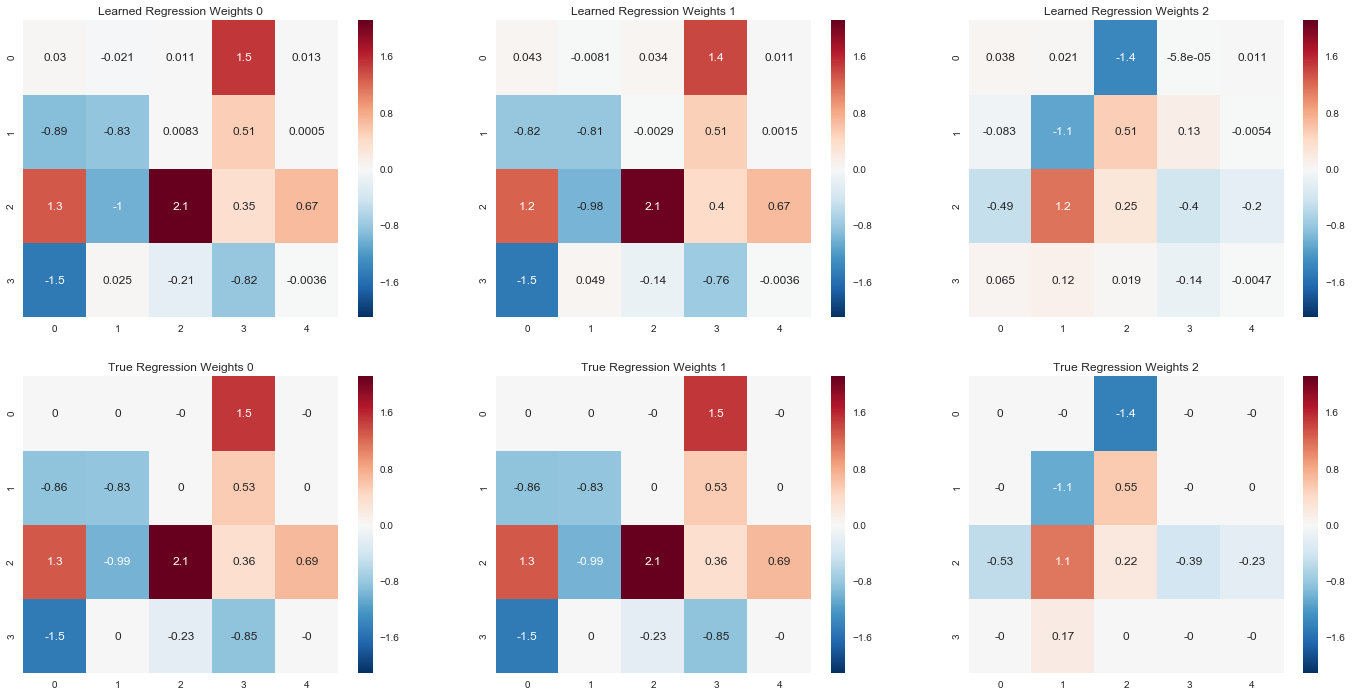

In [71]:
plotHeatmaps( [[B0, B1, B2], B],
  [['Learned Regression Weights 0', 'Learned Regression Weights 1', 'Learned Regression Weights 2'],
   ['True Regression Weights 0',    'True Regression Weights 1',    'True Regression Weights 2']] )

The learned regression coefficients are close to the ground truth values. Where the true values are zero, the learned values are not exactly zero, but they are close. A thresholding step could be used to extract the structures.

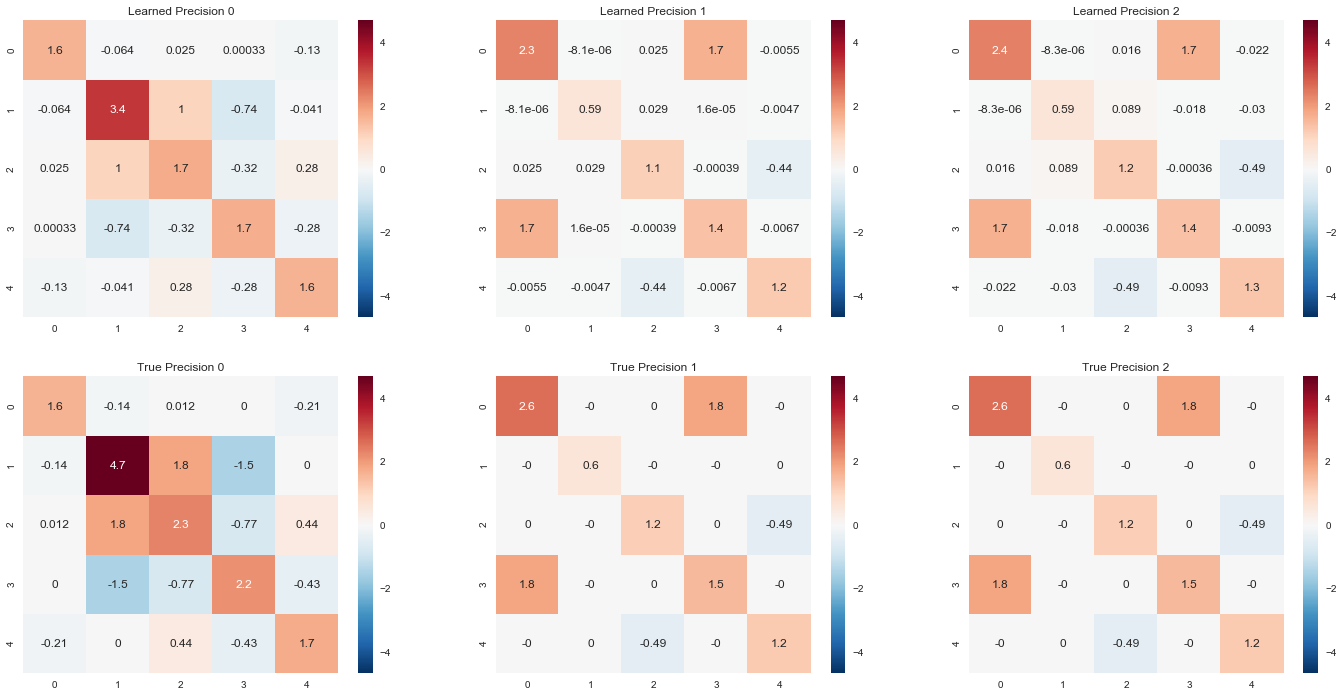

In [72]:
plotHeatmaps(
  [[K0, K1, K2], K],
  [['Learned Precision 0', 'Learned Precision 1', 'Learned Precision 2'],
   ['True Precision 0',    'True Precision 1',    'True Precision 2']] )

The precision structures are learned quite closely, although the learned magnitudes are mostly lower than the true values. The may be due to the sparsifying penalties, or the fusion penalties. For this dataset, the fusion penalties represent prior information that is only partially correct: only 2 of the ground truth precisions are equal, but we have applied penalties to encourage all 3 precisions to be similar.

In [73]:
rP = genVarName()
r( '%s <- cfglPredict(model=%s, X=%s, Y=%s)' % (rP, rTune+'$model', rXXos, rYYos) )
pC = pyArrayFromRVector(rP)

In [74]:
print( classification_report(CCos, pC.argmax(axis=1), target_names=['Class 0', 'Class 1', 'Class 2']) )

             precision    recall  f1-score   support

    Class 0       0.79      0.94      0.86      1000
    Class 1       0.89      0.75      0.81      1000
    Class 2       0.95      0.92      0.94      1000

avg / total       0.88      0.87      0.87      3000



Classification performance is quite good.

In [75]:
rRemove([ rXis, rYis, rXXos, rYYos, rPenB, rPenK, rTune, rP ])